In [1]:
import sys
import numpy as np
sys.path.append("../../")
import data_loading as dl
from importlib import reload
reload(dl)

from plotting import run_plotter as rp
from plotting import histogram as hist

In [2]:
reload(dl)
RUN = [3]

rundata_numu, mc_weights_numu, data_pot_numu = dl.load_runs(
    RUN,
    data="opendata_bnb",
    truth_filtered_sets=["nue", "drt"],
    loadshowervariables=False,
    loadsystematics=True,
    use_bdt=False,
    numupresel=True,
    loadnumuvariables=True,
    load_crt_vars=True
)

/Users/trettin/miniconda/envs/python3LEE/lib/python3.7/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [3]:
reload(hist)
reload(rp)

selection = "NUMUCRT"
preselection = "NUMU"

plotter_numu = rp.Plotter(rundata_numu, selection, preselection, variable="neutrino_energy", data_pot=data_pot_numu)

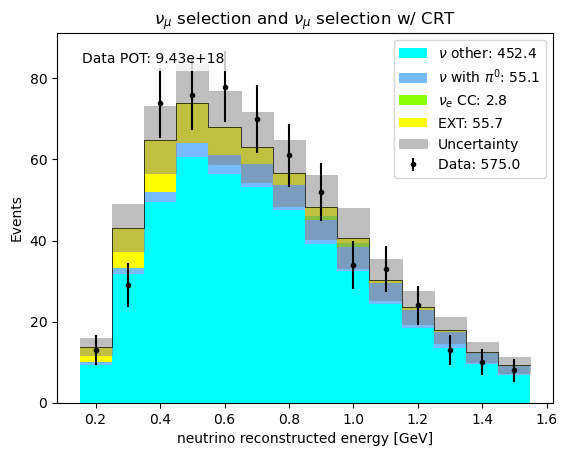

In [139]:
import matplotlib.pyplot as plt
ax = plotter_numu.plot(category_column="paper_category", include_multisim_errors=True, add_ext_error_floor=False, scale_to_pot=None)
# ax.set_ylim((0, 3100))
plt.savefig("plots/numu_sideband.pdf")

In [6]:
reload(dl)
RUN = [1, 2, 3]
rundata, mc_weights, data_pot = dl.load_runs(
    RUN,
    data="bnb",
    truth_filtered_sets=["nue", "drt", "nc_pi0", "cc_pi0", "cc_nopi", "cc_cpi", "nc_nopi", "nc_cpi"],
    loadpi0variables=True,
    loadshowervariables=True,
    loadrecoveryvars=True,
    loadsystematics=True,
    load_lee=True,
)

Loading lee sample
Loading lee sample
Loading lee sample


In [7]:
rundata_no_lee = {k: rundata[k] for k in rundata if k != "lee"}

In [31]:
reload(hist)
reload(rp)

selection = "NPBDT"
preselection = "NP"

plotter = rp.Plotter(rundata, selection, preselection, variable="reco_e", data_pot=data_pot, sideband_generator=plotter_numu)

(0.0, 18.0)

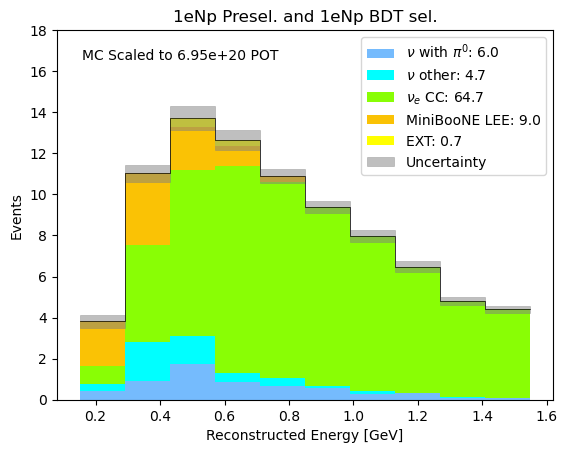

In [140]:
ax = plotter.plot(category_column="paper_category", include_multisim_errors=False, add_ext_error_floor=False, scale_to_pot=6.95E20, use_sideband=False)
# ax.set_xlim((0.15, 1.55))
ax.set_ylim((0, 18))

In [34]:
plotter_h0 = rp.Plotter(rundata_no_lee, selection, preselection, variable="reco_e", data_pot=data_pot, sideband_generator=plotter_numu)

In [144]:
mc_hist = plotter_h0.get_mc_hist(scale_to_pot=6.95e20, include_multisim_errors=True)

In [145]:
mc_hist_w_constr = plotter_h0.get_mc_hist(scale_to_pot=6.95e20, include_multisim_errors=True, use_sideband=True)

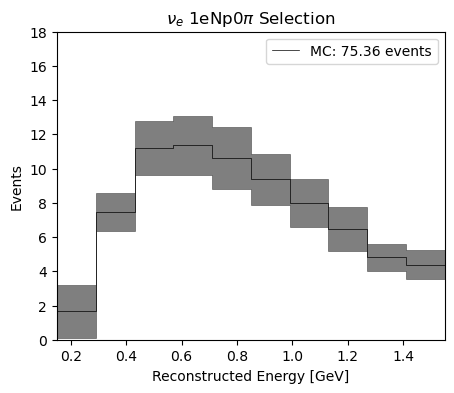

In [147]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 4))
ax = plotter.plot_hist(mc_hist, show_errorband=True, color="k", lw=0.5, label=f"MC: {mc_hist.sum():.2f} events", ax=ax)
ax.legend()
ax.set_xlabel(plotter.xtit)
ax.set_ylabel("Events")
ax.set_xlim((0.15, 1.55))
ax.set_ylim((0, 18))
ax.set_title(r"$\nu_e$ 1eNp0$\pi$ Selection")
plt.savefig("plots/1eNp0pi_no_constr.pdf", bbox_inches="tight")

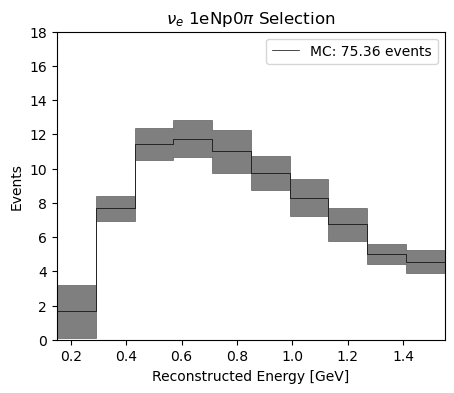

In [148]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 4))
ax = plotter.plot_hist(mc_hist_w_constr, show_errorband=True, color="k", lw=0.5, label=f"MC: {mc_hist.sum():.2f} events", ax=ax)
ax.legend()
ax.set_xlabel(plotter.xtit)
ax.set_ylabel("Events")
ax.set_xlim((0.15, 1.55))
ax.set_ylim((0, 18))
ax.set_title(r"$\nu_e$ 1eNp0$\pi$ Selection")
plt.savefig("plots/1eNp0pi_with_constr.pdf", bbox_inches="tight")

In [105]:
def chi_square(observed_hist, exp_hist):
    n = observed_hist.nominal_values
    mu = exp_hist.nominal_values

    syst_covar = exp_hist.cov_matrix
    # we need to mask off bins where the prediction is empty, otherwise
    # the covariance matrix will be singular
    mask = mu > 0
    syst_covar = syst_covar[np.ix_(mask, mask)]
    mu = mu[mask]
    n = n[mask]

    # this covariance matrix approximates the Poisson uncertainty
    # The equation listed in the Technote is 
    #     np.diag(3 / (1 / n + 2 / mu_h0))
    # but this leads to a division by zero when n = 0.
    # Rearrange the equation to avoid this gives
    #     np.diag(3 * n * mu_h0 / (mu_h0 + 2 * n))
    stat_covar = np.diag(3 * n * mu / (mu + 2 * n))
    total_covar = syst_covar + stat_covar
    covar_inv = np.linalg.inv(total_covar)
    chi2 = np.dot(n - mu, np.dot(covar_inv, n - mu))
    return chi2

def test_statistic(observed_hist, hist_h0, hist_h1):
    """Compute the test statistic for the given observed data and hypotheses."""

    chi2_h0 = chi_square(observed_hist, hist_h0)
    chi2_h1 = chi_square(observed_hist, hist_h1)

    return chi2_h0 - chi2_h1

In [247]:
# the prediction for H1
tot_mc_hist = plotter.get_mc_hist(include_multisim_errors=True, use_sideband=False, scale_to_pot=6.95e20)
ext_hist = plotter.get_data_hist(type="ext", add_error_floor=False)
ext_with_error_floor = plotter.get_data_hist(type="ext", add_error_floor=True)
total_pred_hist_h1 = tot_mc_hist + ext_hist
total_pred_hist_h1.label = "total_h1"
total_pred_hist_h1.tex_string = "H1 Pred."

# the prediction for H0
tot_mc_hist_h0 = plotter_h0.get_mc_hist(include_multisim_errors=True, use_sideband=False, scale_to_pot=6.95e20)
# the EXT hist is the same
total_pred_hist_h0 = tot_mc_hist_h0 + ext_hist
total_pred_hist_h0.label = "total_h0"
total_pred_hist_h0.tex_string = "H0 Pred."

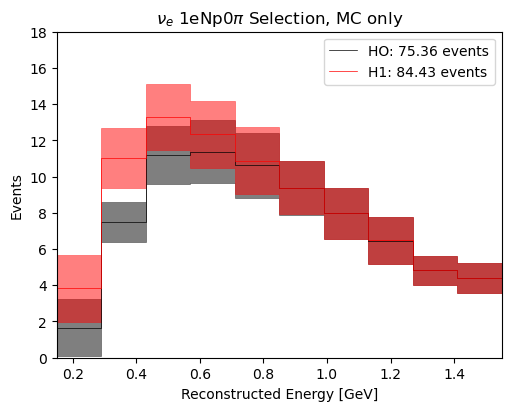

In [197]:
fig, ax = plt.subplots(figsize=(5, 4), constrained_layout=True)
ax = plotter.plot_hist(tot_mc_hist_h0, show_errorband=True, color="k", lw=0.5, label=f"HO: {tot_mc_hist_h0.sum():.2f} events", ax=ax)
ax = plotter.plot_hist(tot_mc_hist, show_errorband=True, color="red", lw=0.5, label=f"H1: {tot_mc_hist.sum():.2f} events", ax=ax)
ax.legend()
ax.set_xlabel(plotter.xtit)
ax.set_ylabel("Events")
ax.set_xlim((0.15, 1.55))
ax.set_ylim((0, 18))
ax.set_title(r"$\nu_e$ 1eNp0$\pi$ Selection, MC only")
plt.savefig("plots/1eNp0pi_mc_only_no_constr.pdf")

In [202]:
ext_with_error_floor = plotter.get_data_hist(type="ext", add_error_floor=True)
total_pred_hist_h0 = tot_mc_hist_h0 + ext_hist
total_pred_hist_h0.label = "total_h0"
total_pred_hist_h0.tex_string = "H0 Pred."

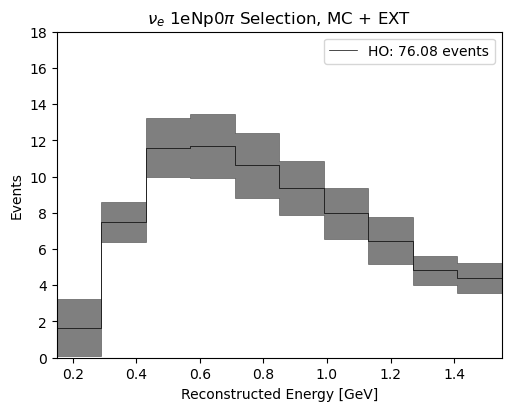

In [203]:
fig, ax = plt.subplots(figsize=(5, 4), constrained_layout=True)
ax = plotter.plot_hist(total_pred_hist_h0, show_errorband=True, color="k", lw=0.5, label=f"HO: {total_pred_hist_h0.sum():.2f} events", ax=ax)
# ax = plotter.plot_hist(total_pred_hist_h1, show_errorband=True, color="red", lw=0.5, label=f"H1: {total_pred_hist_h1.sum():.2f} events", ax=ax)
ax.legend()
ax.set_xlabel(plotter.xtit)
ax.set_ylabel("Events")
ax.set_xlim((0.15, 1.55))
ax.set_ylim((0, 18))
ax.set_title(r"$\nu_e$ 1eNp0$\pi$ Selection, MC + EXT")
plt.savefig("plots/1eNp0pi_mc_ext_no_constr.pdf")

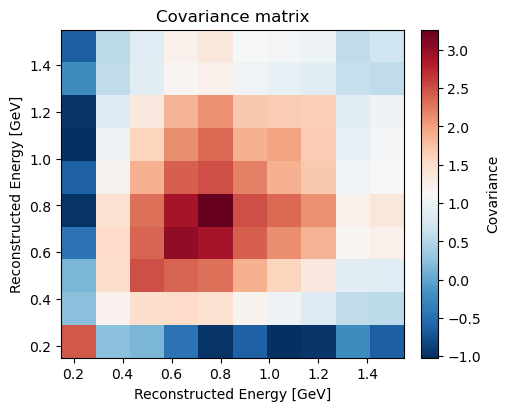

In [204]:
import numpy as np
def plot_correlation(pred_hist, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 4), constrained_layout=True)
    corr_mat = pred_hist.corr_matrix
    bin_centers = pred_hist.bin_centers
    X, Y = np.meshgrid(bin_centers, bin_centers)
    pc = ax.pcolormesh(X, Y, corr_mat.T, cmap="RdBu_r", vmin=-1, vmax=1)
    ax.set_xlabel(plotter.xtit)
    ax.set_ylabel(plotter.xtit)
    ax.set_title("Correlation matrix")
    cbar = fig.colorbar(pc, ax=ax)
    # set label for colorbar
    cbar.set_label("Correlation coefficient")
    return ax

def plot_covariance(pred_hist, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 4), constrained_layout=True)
    cov_mat = pred_hist.cov_matrix
    bin_centers = pred_hist.bin_centers
    X, Y = np.meshgrid(bin_centers, bin_centers)
    pc = ax.pcolormesh(X, Y, cov_mat.T, cmap="RdBu_r")
    ax.set_xlabel(plotter.xtit)
    ax.set_ylabel(plotter.xtit)
    ax.set_title("Covariance matrix")
    cbar = fig.colorbar(pc, ax=ax)
    # set label for colorbar
    cbar.set_label("Covariance")
    return ax

ax = plot_covariance(tot_mc_hist_h0)
plt.show()

In [181]:
# create pseudo-data under H0 and calculate test statistic
test_stat_h0 = []
test_stat_h1 = []


for i in range(10000):
    fluct_pred_hist_h0 = total_pred_hist_h0.fluctuate(seed=4*i)
    fluct_pred_hist_h1 = total_pred_hist_h1.fluctuate(seed=4*i+1)
    observed_h0 = fluct_pred_hist_h0.fluctuate_poisson(seed=4*i+2)
    observed_h1 = fluct_pred_hist_h1.fluctuate_poisson(seed=4*i+3)  # different seed to avoid correlation

    test_stat_h0.append(test_statistic(observed_h0, total_pred_hist_h0, total_pred_hist_h1))
    test_stat_h1.append(test_statistic(observed_h1, total_pred_hist_h0, total_pred_hist_h1))


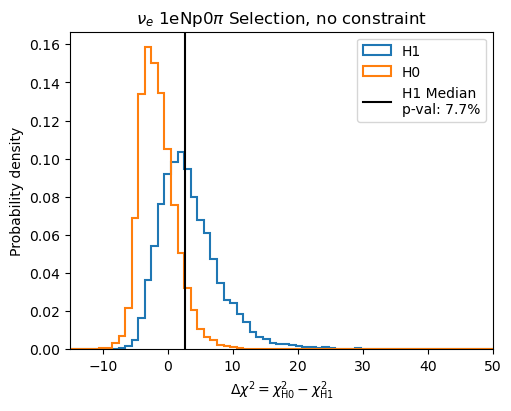

In [192]:
fig, ax = plt.subplots(figsize=(5, 4), constrained_layout=True)
ax.hist(test_stat_h1, bins=np.linspace(-50, 50, 100), label="H1", histtype="step", density=True, lw=1.5)
ax.hist(test_stat_h0, bins=np.linspace(-50, 50, 100), label="H0", histtype="step", density=True, lw=1.5)
median_sensitivity = np.sum(test_stat_h0 > np.median(test_stat_h1)) / len(test_stat_h0)
ax.axvline(np.median(test_stat_h1), color="k", linestyle="-", label=f"H1 Median\np-val: {median_sensitivity:.1%}")


ax.set_xlabel(r"$\Delta \chi^2 = \chi^2_\mathrm{H0} - \chi^2_\mathrm{H1}$")
ax.set_ylabel("Probability density")
ax.legend()
ax.set_xlim((-15, 50))
ax.set_title(r"$\nu_e$ 1eNp0$\pi$ Selection, no constraint")
plt.savefig("plots/test_statistic.pdf")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


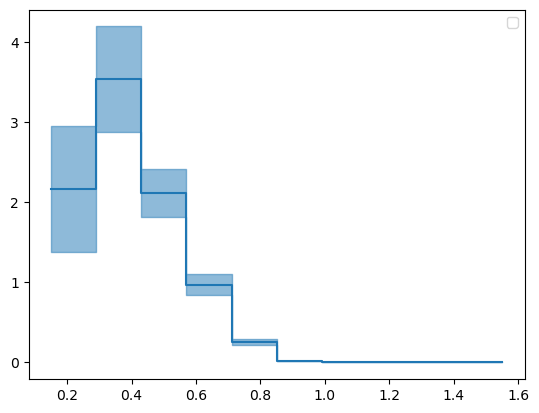

In [235]:
lee_hist = plotter.get_mc_hist(include_multisim_errors=True, use_sideband=False, scale_to_pot=6.95e20, extra_query="dataset_name == 'lee'")
lee_hist

In [248]:
reload(hist)
total_pred_hist_h0 = hist.Histogram.from_dict(total_pred_hist_h0.to_dict())
total_pred_hist_h1 = hist.Histogram.from_dict(total_pred_hist_h1.to_dict())

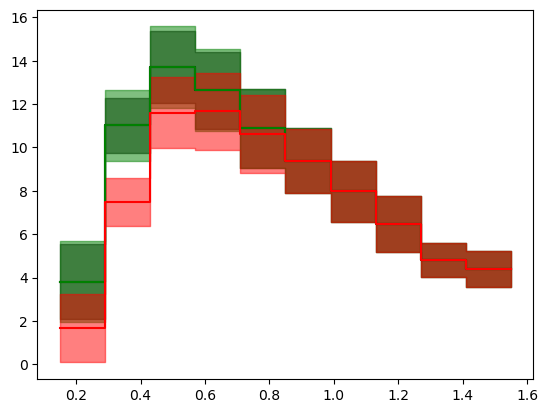

In [249]:
ax = (lee_hist + total_pred_hist_h0).draw(ax=None, color="k")
total_pred_hist_h1.draw(ax=ax, color="g")
total_pred_hist_h0.draw(ax=ax, color="r")

In [300]:
def chi_square(observed_hist, exp_hist):
    n = observed_hist.nominal_values
    mu = exp_hist.nominal_values

    syst_covar = exp_hist.cov_matrix
    # we need to mask off bins where the prediction is empty, otherwise
    # the covariance matrix will be singular
    mask = mu > 0
    syst_covar = syst_covar[np.ix_(mask, mask)]
    mu = mu[mask]
    n = n[mask]

    # this covariance matrix approximates the Poisson uncertainty
    # The equation listed in the Technote is 
    #     np.diag(3 / (1 / n + 2 / mu_h0))
    # but this leads to a division by zero when n = 0.
    # Rearrange the equation to avoid this gives
    #     np.diag(3 * n * mu_h0 / (mu_h0 + 2 * n))
    stat_covar = np.diag(3 * n * mu / (mu + 2 * n))
    total_covar = syst_covar + stat_covar
    covar_inv = np.linalg.inv(total_covar)
    chi2 = np.dot(n - mu, np.dot(covar_inv, n - mu))
    return chi2

In [359]:
from scipy.optimize import minimize_scalar

def fit_background_over_signal(observed, background_hist, signal_hist):
    """Fit a background + signal model to the observed data.
    
    Returns the scaling parameter of the signal that best fits the observed
    data and the chi-square of the best fit.
    """

    def hypothesis(alpha):
        return (signal_hist * alpha) + background_hist
    def loss(alpha):
        return chi_square(observed, hypothesis(alpha))
    
    # minimize the loss wrt alpha, taking into account that alpha >= 0
    result = minimize_scalar(loss, bounds=(0, 10), method="bounded")
    return result.x, result.fun

def pseudo_data(alpha, background_hist, signal_hist, asimov=False, seed=None):
    """Generate pseudo data from a background + signal model."""
    expectation = signal_hist * alpha + background_hist
    if not asimov:
        return expectation.fluctuate_poisson(seed=seed)
    hist_dict = expectation.to_dict()
    # replace errors with the square root of expectation 
    hist_dict["covariance_matrix"] = np.diag(expectation.nominal_values)
    return hist.Histogram.from_dict(hist_dict)

background = total_pred_hist_h0
signal = lee_hist

In [360]:
obs = pseudo_data(1.0, background, signal, asimov=True)
fit_background_over_signal(obs, background, signal)

(0.9999988150835062, 2.452306256023919e-12)

In [343]:
alpha_plot = np.linspace(0, 3, 100)
alpha_truth = 1.0
obs = pseudo_data(alpha_truth, background, signal, asimov=True)
best_fit_alpha, best_fit_chi2 = fit_background_over_signal(obs, background, signal)

chi2_plot = []
for alpha in alpha_plot:
    expectation =  signal * alpha + background
    chi2_plot.append(chi_square(obs, expectation))
chi2_plot = np.array(chi2_plot) - best_fit_chi2

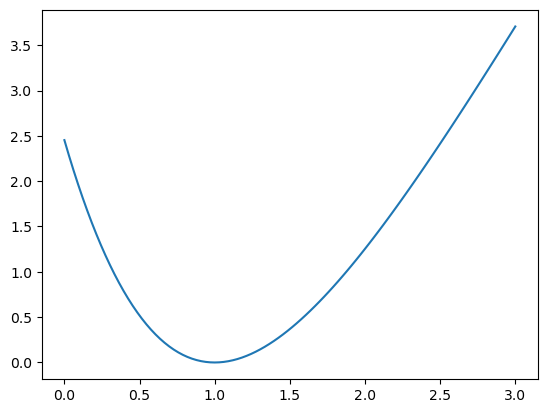

In [344]:
plt.plot(alpha_plot, chi2_plot)

In [366]:
# we want to calculate the full Feldman-Cousins critical values at these points
alpha_fc = np.linspace(0, 3, 20)
cv_1sig = []
cv_2sig = []
cv_90pct = []

for alpha in alpha_fc:
    test_stat = []
    for i in range(2000):
        obs = pseudo_data(alpha, background, signal)
        fit_alpha, fit_chi2 = fit_background_over_signal(obs, background, signal)
        expectation = background + signal * alpha
        test_stat.append(chi_square(obs, expectation) - fit_chi2)
    test_stat = np.array(test_stat)
    cv_1sig.append(np.percentile(test_stat, 68.27))
    cv_2sig.append(np.percentile(test_stat, 95.45))
    cv_90pct.append(np.percentile(test_stat, 90))


In [371]:
def get_asimov_chi2(alpha_eval, alpha_injected):
    obs = pseudo_data(alpha_injected, background, signal, asimov=True)
    expectation =  signal * alpha_eval + background
    return chi_square(obs, expectation)
get_asimov_chi2 = np.vectorize(get_asimov_chi2)

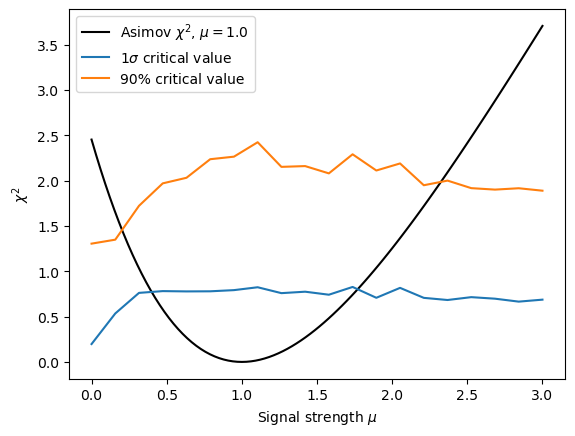

In [394]:
plt.plot(alpha_plot, get_asimov_chi2(alpha_plot, 1.0), color="black", label=r"Asimov $\chi^2$, $\mu=1.0$")
plt.plot(alpha_fc, cv_1sig, label=r"1$\sigma$ critical value")
plt.plot(alpha_fc, cv_90pct, label="90% critical value")

plt.xlabel(r"Signal strength $\mu$")
plt.ylabel(r"$\chi^2$")
plt.legend()
plt.savefig("plots/confidence_band_construction.pdf")

In [369]:
# get interpolated function from the critical values so that we can evaluate it at any value
cv_1sig_interp = lambda x: np.interp(x, alpha_fc, cv_1sig)
cv_90pct_interp = lambda x: np.interp(x, alpha_fc, cv_90pct)

cv_1sig_interp(0.1)

0.4108118293042126

In [375]:
def get_confidence_intervals_asimov(measured_alpha, level="1sig"):
    cv_function = {"1sig": cv_1sig_interp, "90pct": cv_90pct_interp}[level]
    alpha_scan = np.linspace(0, 3, 200)
    chi2_diff =  get_asimov_chi2(alpha_scan, measured_alpha) - cv_function(alpha_scan)
    # The classical confidence region are all values of alpha for which the
    # difference between the chi2 and the critical value is less than zero.
    lower_bound = np.min(alpha_scan[chi2_diff < 0])
    upper_bound = np.max(alpha_scan[chi2_diff < 0])
    return lower_bound, upper_bound

In [382]:
alpha_plot = np.linspace(0, 3, 100)
lower_bounds_1sig, upper_bounds_1sig = [], []
lower_bounds_90pct, upper_bounds_90pct = [], []
for a in alpha_plot:
    lb, ub = get_confidence_intervals_asimov(a, level="1sig")
    lower_bounds_1sig.append(lb)
    upper_bounds_1sig.append(ub)

    lb, ub = get_confidence_intervals_asimov(a, level="90pct")
    lower_bounds_90pct.append(lb)
    upper_bounds_90pct.append(ub)

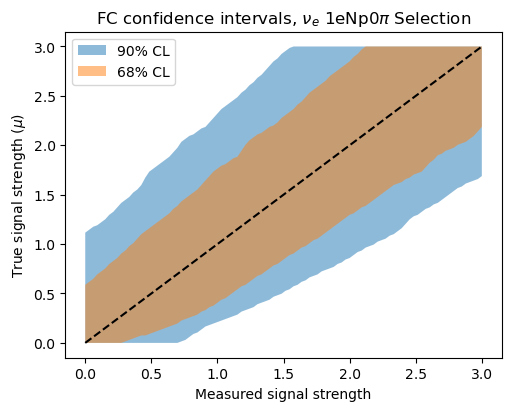

In [390]:
fig, ax = plt.subplots(figsize=(5, 4), constrained_layout=True)
ax.fill_between(alpha_plot, lower_bounds_90pct, upper_bounds_90pct, alpha=0.5, label="90% CL")
ax.fill_between(alpha_plot, lower_bounds_1sig, upper_bounds_1sig, alpha=0.5, label="68% CL")
ax.plot(alpha_plot, alpha_plot, linestyle="--", color="k")
ax.set_xlabel(r"Measured signal strength")
ax.set_ylabel(r"True signal strength ($\mu$)")
ax.set_title(r"FC confidence intervals, $\nu_e$ 1eNp0$\pi$ Selection")
ax.legend()
fig.savefig("plots/fc_belts_1eNp0pi_no_constraint.pdf")